In [6]:
import pyliger
import anndata as ad
from anndata import read_h5ad
import pickle
import time
import scanpy as sc

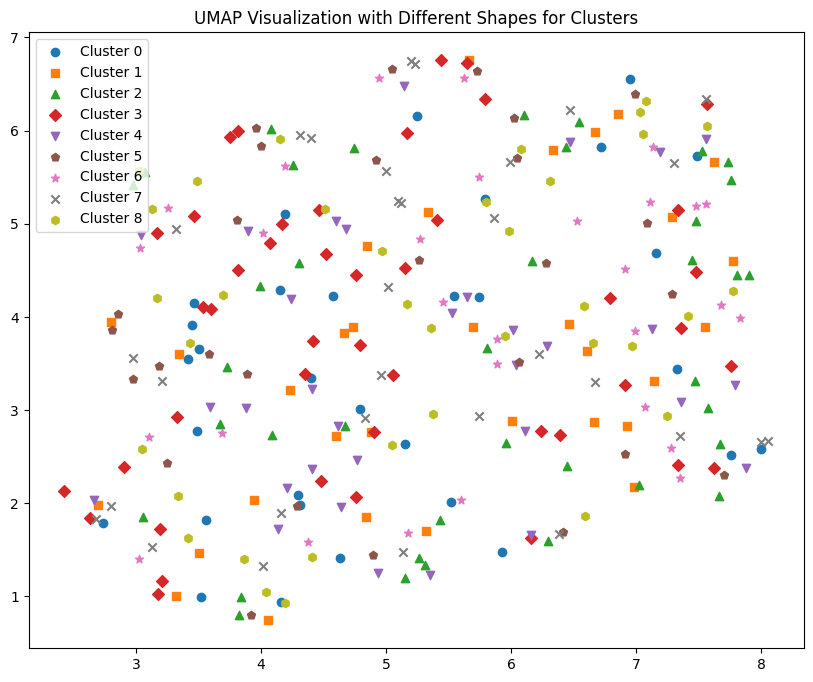

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import umap
%matplotlib inline

# Generate some example data
n_samples = 300
n_clusters = 9
X = np.random.rand(n_samples, 10)
y = np.random.choice(n_clusters, size=n_samples)

# Create UMAP embedding
embedding = umap.UMAP(n_neighbors=10, min_dist=0.1, random_state=42).fit_transform(X)

# Create a list of shapes for each cluster
shapes = ['o', 's', '^', 'D', 'v', 'p', '*', 'x', 'h']

# Create a scatter plot with different shapes for each cluster
plt.figure(figsize=(10, 8))
for cluster_idx in range(n_clusters):
    mask = (y == cluster_idx)
    plt.scatter(embedding[mask, 0], embedding[mask, 1], label=f'Cluster {cluster_idx}', marker=shapes[cluster_idx])

plt.title('UMAP Visualization with Different Shapes for Clusters')
plt.legend()
plt.show()


In [8]:
# bin_50_c5 = read_h5ad('/goofys/Milos/Sharing_data/Adata_bin_50_SS200001209TR_C5.tissue.h5ad')
# bin_50_c6 = read_h5ad('/goofys/Milos/Sharing_data/Adata_bin_50_SS200001209TR_C6.tissue.h5ad')
bin_20_c5 = read_h5ad('/goofys/Milos/Sharing_data/Adata_pp_True_bin_20_SS200001209TR_C5.tissue.h5ad')
bin_20_c6 = read_h5ad('/goofys/Milos/Sharing_data/Adata_pp_True_bin_20_SS200001209TR_C6.tissue.h5ad')
# bin_50_c5.uns['sample_name'] = 'bin_50_c5'
# bin_50_c6.uns['sample_name'] = 'bin_50_c6'
bin_20_c5.uns['sample_name'] = 'bin_20_c5'
bin_20_c6.uns['sample_name'] = 'bin_20_c6'

In [12]:
bin_20_c5

AnnData object with n_obs × n_vars = 157137 × 26904
    obs: 'x', 'y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'geneIDN', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'sample_name'

In [9]:
adata_list = [bin_20_c5, bin_20_c6]

In [10]:
bin_20_c5.var.index.name

'geneID'

In [11]:
bin_20_c5.obs.index.name

'spotID'

In [38]:
def liger(adata_list, normalization = True, norm = 'l1', select_genes = False, scale = True):
    liger_object = pyliger.create_liger(adata_list)
    if normalization:
        pyliger.normalize(liger_object, norm)
    if select_genes:
        # selects HVGs based on Poisson distribution assumption
        pyliger.select_genes(liger_object)
    else:
        # selects ALL genes as HVGs (equal to not performing selection)
        pyliger.select_genes(liger_object, var_thresh=0)
    if scale:
        pyliger.scale_not_center(liger_object)

    return liger_object


In [28]:
liger_object = pyliger.create_liger(adata_list)
pyliger.normalize(liger_object, norm='l2')

In [29]:
pyliger.select_genes(liger_object)

In [30]:
pyliger.scale_not_center(liger_object)

3. Before we can run iNMF on our datasets, we must run several preprocessing steps to normalize expression data to account for differences in sequencing depth and efficiency between cells, identify variably expressed genes, and scale the data so that each gene has the same variance. Note that because nonnegative matrix factorization requires positive values, we do not center the data by subtracting the mean. We also do not log transform the data.

### Stage II: Joint Matrix Factorization (3 - 10 minutes)
4. We are now able to run integrative non-negative matrix factorization on the normalized and scaled datasets. The key parameter for this analysis is k, the number of matrix factors (analogous to the number of principal components in PCA). In general, we find that a value of k between 20 and 40 is suitable for most analyses and that results are robust for choice of k. Because LIGER is an unsupervised, exploratory approach, there is no single “right” value for k, and in practice, users choose k from a combination of biological prior knowledge and other information.

In [39]:
# file_name = adata_list[0].uns['sample_name'][:5]
# for n in ['l1', 'l2', 'max']:
#     print(f"jedan: {n}")
#     liger_object = liger(adata_list, norm=n)
#     for k in [15, 20, 30, 50]:
#         print(f"dva, {k}")
#         liger_object = pyliger.optimize_ALS(liger_object, k = k)
#         for knn in [15, 20, 30, 50]:
#             print("tri")
#             liger_object = pyliger.quantile_norm(liger_object, knn_k=knn)
#             for res in [0.25, 0.5, 1]:
#                 print("cetiri")
#                 liger_object = pyliger.leiden_cluster(liger_object, resolution=res)
#                 liger_object = pyliger.run_umap(liger_object, distance = 'cosine', n_neighbors = 30, min_dist = 0.3)
#                 all_plots = pyliger.plot_by_dataset_and_cluster(liger_object, axis_labels = ['UMAP 1', 'UMAP 2'], return_plots = True)
#                 all_plots[0].save(f"{file_name}_{n}_{k}_{knn}_{res}_1.png", dpi=600)
#                 all_plots[1].save(f"{file_name}_{n}_{k}_{knn}_{res}_2.png", dpi=600)
#                 print("KRAJ")

In [31]:
start = time.time()
pyliger.optimize_ALS(liger_object, k = 20, value_lambda=1,  max_iters=50)
end = time.time()
print(end - start)

  4%|▍         | 2/50 [15:17<6:07:08, 458.92s/it]


KeyboardInterrupt: 

Important parameters are as follows:

* k: Integer value specifying the inner dimension of factorization, or number of factors. Higher k is recommended for datasets with more substructure. We find that a value of k in the range 20 - 40 works well for most datasets. Because this is an unsupervised, exploratory analysis, there is no single “right” value for k, and in practice, users choose k from a combination of biological prior knowledge and other information.
* lambda: This is a regularization parameter. Larger values penalize dataset-specific effects more strongly, causing the datasets to be better aligned, but possibly at the cost of higher reconstruction error. The default value is 5. We recommend using this value for most analyses, but find that it can be lowered to 1 in cases where the dataset differences are expected to be relatively small, such as scRNA-seq data from the same tissue but different individuals. 
* thresh: This sets the convergence threshold. Lower values cause the algorithm to run longer. The default is 1e-6. 
* max_iters: This variable sets the maximum number of iterations to perform. The default value is 30.

The optimization yields several lower dimension matrices, including the **H matrix of metagene loadings for each cell**, the **W matrix of shared factor loadings** and the **V matrices of dataset-specific factor loadings**.

Please note that the time required of this step is highly dependent on the size of the datasets being used. In most cases, this step should not take much longer than 30 minutes.

### Stage III: Quantile Normalization and Joint Clustering (1 minute)
5. We can now use the resulting factors to jointly cluster cells and perform quantile normalization by dataset, factor, and cluster to fully integrate the datasets. All of this functionality is encapsulated within the quantile_norm function, which uses max factor assignment followed by refinement using a k-nearest neighbors graph.

In [22]:
pyliger.quantile_norm(liger_object)

Important parameters of quantile_norm are as follows:

* knn_k This sets the number of nearest neighbors for within-dataset KNN graph. The default is 20.
* quantiles This sets the number of quantiles to use for quantile normalization. The default is 50.
* min_cells This indicates the minimum number of cells to consider a cluster as shared across datasets. The default is 20.
* dims_use This sets the indices of factors to use for quantile normalization. The user can pass in a vector of indices indicating specific factors. This is helpful for excluding factors capturing biological signals such as the cell cycle or technical signals such as mitochondrial genes. The default is all k of the factors.
* do_center This indicates whether to center the data when scaling factors. The default is FALSE. This option should be set to TRUE when metagene loadings have a mean above zero, as with dense data such as DNA methylation.
* max_sample This sets the maximum number of cells used for quantile normalization of each cluster and factor. The default is 1000.
* refine_knn This indicates whether to increase robustness of cluster assignments using KNN graph. The default is TRUE.
* eps This sets the error bound of the nearest neighbor search. The default is 0.9. Lower values give more accurate nearest neighbor graphs but take much longer to computer.
* ref_dataset This indicates the name of the dataset to be used as a reference for quantile normalization. By default, the dataset with the largest number of cells is used.

6. The quantile_norm procedure produces joint clustering assignments and a low-dimensional representation that integrates the datasets together. These joint clusters directly from iNMF can be used for downstream analyses (see below). Alternatively, you can also run Louvain community detection, an algorithm commonly used for single-cell data, on the normalized cell factors. The Louvain/Leiden algorithm excels at merging small clusters into broad cell classes and thus may be more desirable in some cases than the maximum factor assignments produced directly by iNMF.

In [23]:
#pyliger.louvain_cluster(ifnb_liger, resolution = 0.22)
pyliger.leiden_cluster(liger_object, resolution=0.25)

In [24]:
pyliger.run_umap(liger_object, distance = 'cosine', n_neighbors = 30, min_dist = 0.3)

In [25]:
all_plots = pyliger.plot_by_dataset_and_cluster(liger_object, axis_labels = ['UMAP 1', 'UMAP 2'], return_plots = True)
all_plots

[<ggplot: (8772726953141)>, <ggplot: (8772727361227)>]

In [26]:
all_plots[0].save("bin50_c5_c6_pp_l2_tuned_descent.png", dpi=600)
all_plots[1].save("bin50_c5_c6_pp_l2_tuned_descent_clustered.png", dpi=600)

/home/ubuntu/.local/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/ubuntu/.local/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: bin50_c5_c6_pp_l2_tuned_descent.png
/home/ubuntu/.local/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/ubuntu/.local/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: bin50_c5_c6_pp_l2_tuned_descent_clustered.png
